In [1]:
import pandas as pd
from modeling import LightningBinConv
from data import TSDataset, TSDatasetTest
from torch.utils.data import DataLoader
from preprocessing import get_preprocessing_pipeline
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# # download toy dataset to validate the methods
# df = pd.read_csv(
#     "https://raw.githubusercontent.com/AileenNielsen/"
#     "TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",
#     index_col=0,
#     parse_dates=True,
# )
# df.head()

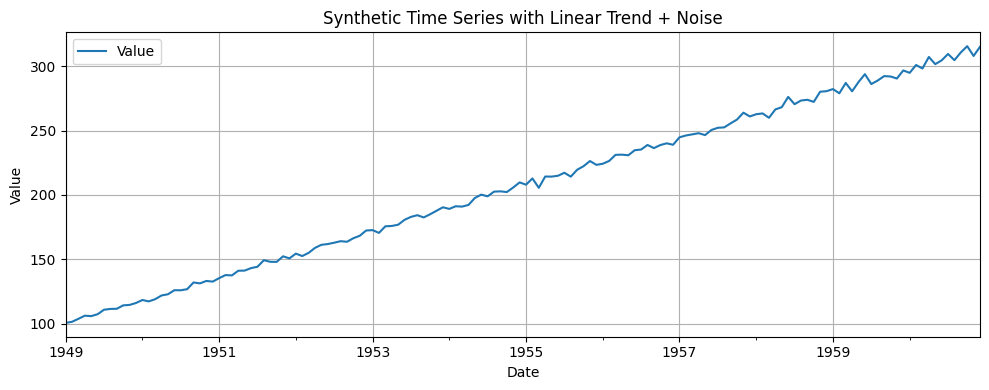

In [3]:
def generate_noisy_linear_trend_series(start="1949-01-01", end="1960-12-01",
                                       start_value=100, slope=1.5, noise_std=0.01, random_seed=42):
    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Create monthly date range
    dates = pd.date_range(start=start, end=end, freq='MS')
    n = len(dates)

    # Generate linear trend
    trend = start_value + slope * np.arange(n)

    # Add Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_std, size=n)
    values = trend + noise*trend

    # Create DataFrame
    df = pd.DataFrame({
        'Date': dates,
        'Value': values
    }).set_index('Date')

    return df

# Generate the data
df = generate_noisy_linear_trend_series()

# Plot the result
df.plot(title="Synthetic Time Series with Linear Trend + Noise", figsize=(10, 4))
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show first few rows
# print(df.head())

In [101]:
#hyperparameters
context_length = 72
num_bins = 1000
min_value = -2
max_value = 2
offset = -24 # for train/test split
train_test_intersection = 24
prediction_length = 24 + train_test_intersection

In [102]:
train_data = df.values[:offset]
test_data = df.values[offset-context_length-train_test_intersection:]

In [103]:
pipeline = get_preprocessing_pipeline(num_bins=num_bins, min_val=min_value, max_val=max_value)

num bins: 1000
min_val: -2
max_val: 2


In [104]:
net = LightningBinConv(
    lr=1e-1,
    is_prob_forecast=False,
    dropout=0.0,
    min_bin_value=min_value,
    max_bin_value=max_value,
    num_blocks=1,
    context_length=context_length,
    num_bins=num_bins,
    kernel_size_across_bins_2d=3,
    kernel_size_across_bins_1d=3,
    num_filters_2d= context_length,
    num_filters_1d= context_length,
    prediction_length=prediction_length,
    is_cum_sum = False,
    last_layer='conv'
)

dropout:0.0
target dim: 1
per sample scaler type is None
activation functions after conv2d:
ModuleList(
  (0): ModuleList(
    (0): DynamicTanh(normalized_shape=72, alpha_init_value=0.5, channels_last=False)
  )
)
target dim: 0
conv 2d layers:
ModuleList(
  (0): Conv2d(1, 72, kernel_size=(72, 3), stride=(1, 1))
)
conv 1d layers:
ModuleList(
  (0): ModuleList(
    (0-1): 2 x Conv1d(72, 72, kernel_size=(3,), stride=(1,), groups=72)
  )
)
conv ffn layer:
Conv1d(72, 1, kernel_size=(51,), stride=(1,))


In [105]:
dataset = TSDataset(data=train_data, context_length=context_length, scaler=pipeline)
train_loader = DataLoader(dataset, batch_size=int(1e6), shuffle=True)

In [106]:
net

LightningBinConv(
  (dropout): Dropout(p=0.0, inplace=False)
  (act): ModuleList(
    (0): ModuleList(
      (0): DynamicTanh(normalized_shape=72, alpha_init_value=0.5, channels_last=False)
    )
  )
  (layers): ModuleList(
    (0): ModuleDict(
      (conv2d): ModuleList(
        (0): Conv2d(1, 72, kernel_size=(72, 3), stride=(1, 1))
      )
      (conv1d): ModuleList(
        (0): ModuleList(
          (0-1): 2 x Conv1d(72, 72, kernel_size=(3,), stride=(1,), groups=72)
        )
      )
      (conv_ffn): Conv1d(72, 1, kernel_size=(51,), stride=(1,))
      (act): ModuleList(
        (0): ModuleList(
          (0): DynamicTanh(normalized_shape=72, alpha_init_value=0.5, channels_last=False)
        )
      )
    )
  )
)

In [ ]:
trainer = pl.Trainer(max_epochs=500)
trainer.fit(net, train_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | dropout | Dropout    | 0      | train
1 | act     | ModuleList | 145    | train
2 | layers  | ModuleList | 20.0 K | train
-----------------------------------------------
20.2 K    Trainable params
0         Non-trainable params
20.2 K    Total params
0.081     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in t

Training: |          | 0/? [00:00<?, ?it/s]

tensor(0.5421, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(11.1198, device='mps:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(10.6423, device='mps:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(6.9977, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(4.0857, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(2.1603, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.0019, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5587, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5082, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4976, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4986, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4968, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4926, device='m

In [ ]:
test_dataset = TSDatasetTest(data=test_data, context_length=context_length, scaler=train_loader.dataset.scaler)
test_loader = DataLoader(test_dataset, batch_size=int(1e6),shuffle=False)

In [ ]:
test_sample = next(iter(test_loader))

In [ ]:
test_sample.shape

In [ ]:
import numpy as np

#TODO: this is ugly, rewrite in future
def extract_forecasts(pred_samples, window, context_length):
    """
    Extracts and concatenates forecast windows from pred_samples.

    Args:
        pred_samples (np.ndarray): Array of prediction samples (e.g. [num_samples, forecast_len]).
        window (int): Number of forecast windows to extract.
        context_length (int): Number of context steps between each forecast start.

    Returns:
        np.ndarray: Concatenated forecast windows.
    """
    indices = [(i * (context_length + 1)) for i in range(window)]
    windows = [pred_samples[i][:context_length] for i in indices]
    return np.concatenate(windows)

In [ ]:
%%time
pred_samples = net.forecast(test_sample, context_length)
pred_samples = pred_samples.squeeze()
pred_samples = pipeline.inverse_transform(pred_samples.numpy())

In [ ]:
pred  = extract_forecasts(pred_samples, 1, context_length)

In [ ]:
pred

In [ ]:
mae = np.mean(np.abs(pred - test_data[context_length:]))
print(f"MAE: {mae:.4f}")

In [ ]:
plt.plot(test_data[context_length:], c='r')
plt.plot(pred)

In [ ]:
2*pipeline['scaler'].means_

In [ ]:
df.to_csv('fact.csv')

In [ ]:
pd.Series(pred).to_csv('conv.csv')